In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

import species

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
'''
species = [
    #'CO_12_HITEMP', 
    #'CO_13_HITEMP', 
    'H2O_Exomol', 
    'CH4', 
    'NH3', 
    'CO2', 
    'HCN', 
    ]

masses = {
    'CO': 13+16, #12+16,- 
    'H2O': 2*1+16, 
    'CH4': 12+4*1, 
    'NH3': 14+3*1, 
    'CO2': 12+2*16, 
    'HCN': 1+12+14
}

atmosphere = Radtrans(line_species = species,
                      wlen_bords_micron = [0.1, 251.]) # DO NOT CHANGE THESE WAVELENGTH BOUNDS FOR THE REBINNING!

atmosphere.write_out_rebin(300,
                           path='rebin_test',
                           species = species,
                           masses = masses)
'''

"\nspecies = [\n    #'CO_12_HITEMP', \n    #'CO_13_HITEMP', \n    'H2O_Exomol', \n    'CH4', \n    'NH3', \n    'CO2', \n    'HCN', \n    ]\n\nmasses = {\n    'CO': 13+16, #12+16,- \n    'H2O': 2*1+16, \n    'CH4': 12+4*1, \n    'NH3': 14+3*1, \n    'CO2': 12+2*16, \n    'HCN': 1+12+14\n}\n\natmosphere = Radtrans(line_species = species,\n                      wlen_bords_micron = [0.1, 251.]) # DO NOT CHANGE THESE WAVELENGTH BOUNDS FOR THE REBINNING!\n\natmosphere.write_out_rebin(300,\n                           path='rebin_test',\n                           species = species,\n                           masses = masses)\n"

## Quenched equilibrium

In [3]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_', n_params=29
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

pRT_atm_2 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/pRT_atm_broad.pkl'
    )
pRT_atm_2.params = bestfit_params_2['params']

magnitudes = {
    #'GAIA/GAIA.G': (18.598427, 0.003844), 
    '2MASS/2MASS.J': (13.25, 0.03), # Dupuy et al. (2012)
    '2MASS/2MASS.H': (12.20, 0.02), 
    '2MASS/2MASS.Ks': (11.56, 0.02), 
    #'MKO/MKO.K': (11.551, 0.024), 
    'WISE/WISE.W1': (10.77, 0.02), # Gagne et al. (2015)
    'WISE/WISE.W2': (10.21, 0.02), 
}

  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_.txt
(3935, 29)


In [8]:
import petitRADTRANS.poor_mans_nonequ_chem as pm

def quench_carbon_chemistry(params, pressure, temperature):

    CO = params['C/O']
    FeH = params['Fe/H']
    P_quench = params['P_quench']
    C_ratio = params['C_ratio']

    pm_mass_fractions = pm.interpol_abundances(
        CO*np.ones_like(pressure), 
        FeH*np.ones_like(pressure), 
        temperature, 
        pressure
        )
    
    mass_fractions = {
        'MMW': pm_mass_fractions['MMW'], 
        }

    return mass_fractions

def K_zz(pressure, temperature, P_quench, mass_fractions, m, log_g, alpha=1):
    
    T_quench = np.interp(P_quench, pressure, temperature)
    MMW_quench = np.interp(P_quench, pressure, mass_fractions['MMW'])

    def t_q1():
        return (1.5e-6) * (P_quench)**(-1) * (m)**(-0.7) * np.exp(42000/T_quench)
    
    def t_q2():
        return (40) * (P_quench)**(-2) * np.exp(25000/T_quench)
    
    # Zahnle & Marley (2014)
    t_chem = (1/t_q1() + 1/t_q2())**(-1)
    #print(t_chem)

    # Mixing timescale matches chemical timescale at quench point
    t_mix = t_chem

    # Scale height
    H = (nc.kB*T_quench / (MMW_quench*nc.amu*10**log_g))

    # Mixing length scale
    L = alpha*H

    # Vertical diffusion coefficient
    K_zz = L**2 / t_mix

    return K_zz, t_chem

upper_K_zz = 2.5e10 * (1400/600)**(8/3) * (1000/10**bestfit_params_2['params']['log_g'])
print('Upper K_zz < {:.3e} cm s^-2'.format(upper_K_zz))

params = bestfit_params_2['params']
K_zz_posterior, t_chem_posterior = [], []
for i, sample_i in enumerate(posterior_2):
    
    params['R_p'] = sample_i[8]
    params['log_g'] = sample_i[9]
    params['epsilon_limb'] = sample_i[10]
    params['vsini'] = sample_i[11]
    params['rv'] = sample_i[12]
    
    params['opa_base_gray'] = 10**sample_i[13]
    params['P_base_gray'] = 10**sample_i[14]
    params['f_sed_gray'] = sample_i[15]

    params['C/O'] = sample_i[16]
    params['Fe/H'] = sample_i[17]
    params['P_quench'] = 10**sample_i[18]
    params['C_ratio'] = 10**sample_i[19]

    params['T_0'] = sample_i[21]
    params['T_1'] = sample_i[22]
    params['T_2'] = sample_i[23]
    params['T_3'] = sample_i[24]
    params['T_4'] = sample_i[25]
    params['T_5'] = sample_i[26]
    params['T_6'] = sample_i[27]

    params['d_log_P_01'] = sample_i[28]
    params['log_P_knots'] = np.array([
        -6.0, 
        2.0-params['d_log_P_45']-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
        2.0-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
        2.0-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
        2.0-params['d_log_P_12']-params['d_log_P_01'], 
        2.0-params['d_log_P_01'], 
        2.0
        ])
    params['P_knots'] = 10**params['log_P_knots']
    
    params['T_knots'] = np.array([
        params['T_6'], 
        params['T_5'], 
        params['T_4'], 
        params['T_3'], 
        params['T_2'], 
        params['T_1'], 
        #params['T_0'], 
        ])

    # Compute the PT profile
    temperature = PT_2(params)

    #temperature *= 0.95

    # Compute the VMR profiles
    mass_fractions = quench_carbon_chemistry(params, PT_2.pressure, temperature)

    K_zz_i, t_chem_i = K_zz(
        PT_2.pressure, temperature, 
        params['P_quench'], mass_fractions, m=1, 
        log_g=params['log_g'], 
        alpha=1
        )
    
    K_zz_posterior.append(K_zz_i)
    t_chem_posterior.append(t_chem_i)

K_zz_posterior = np.array(K_zz_posterior)
t_chem_posterior = np.array(t_chem_posterior)
#print('K_zz = {:.3e} | {:.3e} | {:.3e}'.format(*np.percentile(K_zz_posterior, q=[16,50,84])))

median = np.percentile(K_zz_posterior, q=50)
low  = np.percentile(K_zz_posterior, q=16) - median
high = np.percentile(K_zz_posterior, q=84) - median
print('K_zz = {:.1e} +{:.1e} {:.1e}'.format(median, high, low))

median = np.percentile(t_chem_posterior, q=50)
low  = np.percentile(t_chem_posterior, q=16) - median
high = np.percentile(t_chem_posterior, q=84) - median
print('t_chem = {:.1f} +{:.1f} {:.1f}'.format(median, high, low))
#K_zz = K_zz(Chem_2, PT_2, 1, bestfit_params_2['params']['log_g'], alpha=0.1)
#print('K_zz = {:.3e} cm s^-2'.format(K_zz))

Upper K_zz < 9.494e+08 cm s^-2
K_zz = 5.6e+10 +4.2e+10 -2.8e+10
t_chem = 2.4 +2.3 -0.9


In [ ]:
pRT_atm = Radtrans(
    line_species=[
        'CO_12_HITEMP_R_300', 
        'CO_13_HITEMP_R_300', 
        'H2O_Exomol_R_300', 
        'CH4_R_300', 
        'NH3_R_300', 
        'CO2_R_300', 
        'HCN_R_300', 
        #'FeH', 
        #'H2S', 
        ], 
    rayleigh_species=['H2', 'He'], 
    continuum_opacities=['H2-H2', 'H2-He'], 
    wlen_bords_micron=[0.3,15], 
    )

pRT_atm.setup_opa_structure(PT_2.pressure)

In [ ]:
import petitRADTRANS.poor_mans_nonequ_chem as pm

species_pRT_names = {
    'CO': 'CO_12_HITEMP_R_300', 
    '13CO': 'CO_13_HITEMP_R_300', 
    'H2O': 'H2O_Exomol_R_300', 
    'CH4': 'CH4_R_300', 
    'NH3': 'NH3_R_300', 
    'CO2': 'CO2_R_300', 
    'HCN': 'HCN_R_300', 
    #'FeH': 'FeH', 
    #'H2S': 'H2S', 
    'H2': 'H2', 
    'He': 'He', 
    }

def quench_carbon_chemistry(params, pressure, temperature):

    CO = params['C/O']
    FeH = params['Fe/H']
    P_quench = params['P_quench']
    C_ratio = params['C_ratio']

    pm_mass_fractions = pm.interpol_abundances(
        CO*np.ones_like(pressure), 
        FeH*np.ones_like(pressure), 
        temperature, 
        pressure
        )

    # Layers to be replaced by a constant abundance
    mask_quenched = (pressure < P_quench)

    unquenched_mass_fractions = {}

    for i, species_i in enumerate(['CO', 'CH4', 'H2O']):
        
        # Store the unquenched abundance profiles
        #line_species_i = self.read_species_info(['12CO', 'CH4', 'H2O'][i], 'pRT_name')
        line_species_i = species_pRT_names[species_i]
        unquenched_mass_fractions[line_species_i] = np.copy(pm_mass_fractions[species_i])

        # Own implementation of quenching, using interpolation
        mass_fraction_i = pm_mass_fractions[species_i]
        mass_fraction_i[mask_quenched] = np.interp(P_quench, xp=pressure, fp=mass_fraction_i)
        pm_mass_fractions[species_i] = mass_fraction_i

    mass_fractions = {
        'MMW': pm_mass_fractions['MMW'], 

        'CO_12_HITEMP_R_300': (1 - C_ratio*(13+16)/(12+16)) * pm_mass_fractions['CO'], 
        'CO_13_HITEMP_R_300': C_ratio*(13+16)/(12+16) * pm_mass_fractions['CO'], 

        'H2O_Exomol_R_300': pm_mass_fractions['H2O'], 
        'CH4_R_300': pm_mass_fractions['CH4'], 
        'NH3_R_300': pm_mass_fractions['NH3'], 
        'CO2_R_300': pm_mass_fractions['CO2'], 
        'HCN_R_300': pm_mass_fractions['HCN'], 
        #'FeH': pm_mass_fractions['FeH'], 
        #'H2S': pm_mass_fractions['H2S'], 
        'H2': pm_mass_fractions['H2'], 
        'He': pm_mass_fractions['He'], 
        }

    return mass_fractions, unquenched_mass_fractions

from tqdm import tqdm
def get_flux_posterior(bestfit_params, posterior, PT, Chem):

    flux_posterior = []
    scaled_flux_posterior = []

    params = bestfit_params.copy()

    for i, sample in enumerate(tqdm(posterior[:])):
        
        params['R_p'] = sample[8]
        params['log_g'] = sample[9]
        params['epsilon_limb'] = sample[10]
        params['vsini'] = sample[11]
        params['rv'] = sample[12]
        
        params['opa_base_gray'] = 10**sample[13]
        params['P_base_gray'] = 10**sample[14]
        params['f_sed_gray'] = sample[15]

        params['C/O'] = sample[16]
        params['Fe/H'] = sample[17]
        params['P_quench'] = 10**sample[18]
        params['C_ratio'] = 10**sample[19]

        params['T_0'] = sample[21]
        params['T_1'] = sample[22]
        params['T_2'] = sample[23]
        params['T_3'] = sample[24]
        params['T_4'] = sample[25]
        params['T_5'] = sample[26]
        params['T_6'] = sample[27]
        
        params['d_log_P_01'] = sample[28]
        params['log_P_knots'] = np.array([
            -6.0, 
            2.0-params['d_log_P_45']-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_01'], 
            2.0
            ])
        params['P_knots'] = 10**params['log_P_knots']
        
        params['T_knots'] = np.array([
            params['T_6'], 
            params['T_5'], 
            params['T_4'], 
            params['T_3'], 
            params['T_2'], 
            params['T_1'], 
            #params['T_0'], 
            ])


        # Compute the PT profile
        temperature = PT(params)

        
        mass_fractions, _ = quench_carbon_chemistry(params, PT_2.pressure, temperature)

        pRT_atm_2.params = params

        # Generate the pRT model spectrum 
        pRT_atm.calc_flux(
            temperature, 
            mass_fractions, 
            gravity=10**params['log_g'], 
            mmw=mass_fractions['MMW'], 
            give_absorption_opacity=pRT_atm_2.gray_cloud_opacity, 
            )
        wave = nc.c / pRT_atm.freq
        flux = pRT_atm.flux

        # Convert [erg cm^{-2} s^{-1} Hz^{-1}] -> [erg cm^{-2} s^{-1} cm^{-1}]
        flux *= nc.c / (wave**2)

        # Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
        flux /= 1e7

        # Convert [erg cm^{-2} s^{-1} nm^{-1}] -> [W cm^{-2} nm^{-1}]
        flux *= 1e-7

        # Convert [W cm^{-2} nm^{-1}] -> [W m^{-2} nm^{-1}]
        flux /= (1e-2)**2

        # Convert [W m^{-2} nm^{-1}] -> [W m^{-2} um^{-1}]
        flux /= 1e-3

        # Convert [cm] -> [nm]
        #wave *= 1e7

        # Convert [cm] -> [um]
        wave *= 1e4

        flux_posterior.append(flux)

        # Convert to observation by scaling with planetary radius
        scaled_flux_posterior.append(flux*(params['R_p']*nc.r_jup_mean / (1e3/params['parallax']*nc.pc))**2)

    return wave, np.array(flux_posterior), np.array(scaled_flux_posterior)

wave, flux_posterior, scaled_flux_posterior = get_flux_posterior(bestfit_params_2['params'], posterior_2, PT_2, Chem_2)

In [ ]:
q = 0.5 + 1/100 * np.array([-99.7,-95,-68,0,68,95,99.7])/2

flux_conf_interval = np.quantile(flux_posterior, q=q, axis=0)
scaled_flux_conf_interval = np.quantile(scaled_flux_posterior, q=q, axis=0)

synth_flux_posterior = {}
synth_flux_conf_interval = {}
for key, val in magnitudes.items():
    synphot = species.SyntheticPhotometry(key)

    synth_flux_posterior[key] = []
    
    for flux_i in scaled_flux_posterior:
        synth_flux_i, _ = synphot.spectrum_to_flux(wave, flux_i)
        synth_flux_posterior[key].append(synth_flux_i)

    synth_flux_conf_interval[key] = np.quantile(np.array(synth_flux_posterior[key]), q=q)

In [ ]:
np.save('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_flux_envelope.npy', flux_conf_interval)
np.save('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_scaled_flux_envelope.npy', scaled_flux_conf_interval)
np.save('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_wave.npy', wave)

In [ ]:
T_eff_posterior = np.array([
    (np.trapz(flux_i, x=wave) / (5.67051e-8))**(1/4) \
    for flux_i in flux_posterior
    ])
np.save('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/T_eff_posterior.npy', T_eff_posterior)

## Fiducial model

In [ ]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

pRT_atm_1 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_nominal_5/test_data/pRT_atm_broad.pkl'
    )
pRT_atm_1.params = bestfit_params_1['params']

magnitudes = {
    '2MASS/2MASS.J': (13.25, 0.03), # Dupuy et al. (2012)
    '2MASS/2MASS.H': (12.20, 0.02), 
    '2MASS/2MASS.Ks': (11.56, 0.02), 
    #'MKO/MKO.K': (11.551, 0.024), 
    'WISE/WISE.W1': (10.77, 0.02), # Gagne et al. (2015)
    'WISE/WISE.W2': (10.21, 0.02), 
}

In [ ]:
pRT_atm = Radtrans(
    line_species=[
        'CO_12_HITEMP_R_300', 
        'CO_13_HITEMP_R_300', 
        'H2O_Exomol_R_300', 
        'CH4_R_300', 
        'NH3_R_300', 
        'CO2_R_300', 
        'HCN_R_300', 
        ], 
    rayleigh_species=['H2', 'He'], 
    continuum_opacities=['H2-H2', 'H2-He'], 
    wlen_bords_micron=[0.3,15], 
    )

pRT_atm.setup_opa_structure(PT_1.pressure)

In [ ]:
from tqdm import tqdm

def get_flux_posterior(bestfit_params, posterior, PT, Chem):

    flux_posterior = []
    scaled_flux_posterior = []

    params = bestfit_params.copy()

    for i, sample in enumerate(tqdm(posterior[:])):
        
        params['R_p'] = sample[8]
        params['log_g'] = sample[9]
        params['epsilon_limb'] = sample[10]
        params['vsini'] = sample[11]
        params['rv'] = sample[12]
        
        params['opa_base_gray'] = 10**sample[13]
        params['P_base_gray'] = 10**sample[14]
        params['f_sed_gray'] = sample[15]

        params['T_0'] = sample[24]
        params['T_1'] = sample[25]
        params['T_2'] = sample[26]
        params['T_3'] = sample[27]
        params['T_4'] = sample[28]
        params['T_5'] = sample[29]
        params['T_6'] = sample[30]
        
        params['d_log_P_01'] = sample[31]
        params['log_P_knots'] = np.array([
            -6.0, 
            2.0-params['d_log_P_45']-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_01'], 
            2.0
            ])
        params['P_knots'] = 10**params['log_P_knots']
        
        params['T_knots'] = np.array([
            params['T_6'], 
            params['T_5'], 
            params['T_4'], 
            params['T_3'], 
            params['T_2'], 
            params['T_1'], 
            #params['T_0'], 
            ])

        # Compute the PT profile
        temperature = PT(params)

        
        mass_fractions = {
            'H2': Chem_1.mass_fractions_posterior.get('H2')[i], 
            'He': Chem_1.mass_fractions_posterior.get('He')[i], 
            'CO_12_HITEMP_R_300': Chem_1.mass_fractions_posterior.get('CO_main_iso')[i], 
            'CO_13_HITEMP_R_300': Chem_1.mass_fractions_posterior.get('CO_36')[i], 
            'H2O_Exomol_R_300': Chem_1.mass_fractions_posterior.get('H2O_pokazatel_main_iso')[i], 
            'CH4_R_300': Chem_1.mass_fractions_posterior.get('CH4_hargreaves_main_iso')[i], 
            'NH3_R_300': Chem_1.mass_fractions_posterior.get('NH3_coles_main_iso')[i], 
            'CO2_R_300': Chem_1.mass_fractions_posterior.get('CO2_main_iso')[i], 
            'HCN_R_300': Chem_1.mass_fractions_posterior.get('HCN_main_iso')[i], 
            }

        pRT_atm_1.params = params

        # Generate the pRT model spectrum 
        pRT_atm.calc_flux(
            temperature, 
            mass_fractions, 
            gravity=10**params['log_g'], 
            mmw=Chem.mass_fractions_posterior['MMW'][i], 
            give_absorption_opacity=pRT_atm_1.gray_cloud_opacity, 
            )
        wave = nc.c / pRT_atm.freq
        flux = pRT_atm.flux

        # Convert [erg cm^{-2} s^{-1} Hz^{-1}] -> [erg cm^{-2} s^{-1} cm^{-1}]
        flux *= nc.c / (wave**2)

        # Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
        flux /= 1e7

        # Convert [erg cm^{-2} s^{-1} nm^{-1}] -> [W cm^{-2} nm^{-1}]
        flux *= 1e-7

        # Convert [W cm^{-2} nm^{-1}] -> [W m^{-2} nm^{-1}]
        flux /= (1e-2)**2

        # Convert [W m^{-2} nm^{-1}] -> [W m^{-2} um^{-1}]
        flux /= 1e-3

        # Convert [cm] -> [nm]
        #wave *= 1e7

        # Convert [cm] -> [um]
        wave *= 1e4

        flux_posterior.append(flux)

        # Convert to observation by scaling with planetary radius
        scaled_flux_posterior.append(flux*(params['R_p']*nc.r_jup_mean / (1e3/params['parallax']*nc.pc))**2)

    return wave, np.array(flux_posterior), np.array(scaled_flux_posterior)

wave, flux_posterior, scaled_flux_posterior = get_flux_posterior(bestfit_params_1['params'], posterior_1, PT_1, Chem_1)

In [ ]:
q = 0.5 + 1/100 * np.array([-99.7,-95,-68,0,68,95,99.7])/2

flux_conf_interval = np.quantile(flux_posterior, q=q, axis=0)
scaled_flux_conf_interval = np.quantile(scaled_flux_posterior, q=q, axis=0)

synth_flux_posterior = {}
synth_flux_conf_interval = {}
for key, val in magnitudes.items():
    synphot = species.SyntheticPhotometry(key)

    synth_flux_posterior[key] = []
    
    for flux_i in scaled_flux_posterior:
        synth_flux_i, _ = synphot.spectrum_to_flux(wave, flux_i)
        synth_flux_posterior[key].append(synth_flux_i)

    synth_flux_conf_interval[key] = np.quantile(np.array(synth_flux_posterior[key]), q=q)

In [ ]:
np.save('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_flux_envelope.npy', flux_conf_interval)
np.save('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_scaled_flux_envelope.npy', scaled_flux_conf_interval)
np.save('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_wave.npy', wave)

In [ ]:
T_eff_posterior = np.array([
    (np.trapz(flux_i, x=wave) / (5.67051e-8))**(1/4) \
    for flux_i in flux_posterior
    ])
np.save('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/T_eff_posterior.npy', T_eff_posterior)

## Make the photometry comparison plot

In [4]:
flux_conf_interval_1 = np.load('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_flux_envelope.npy')
scaled_flux_conf_interval_1 = np.load('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_scaled_flux_envelope.npy')
wave_1 = np.load('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/low_res_wave.npy')

flux_conf_interval_2 = np.load('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_flux_envelope.npy')
scaled_flux_conf_interval_2 = np.load('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_scaled_flux_envelope.npy')
wave_2 = np.load('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/low_res_wave.npy')

In [5]:
posterior_color_1 = '#8B077C'
posterior_color_2 = '#075B56'
posterior_color_3 = '#C25617'

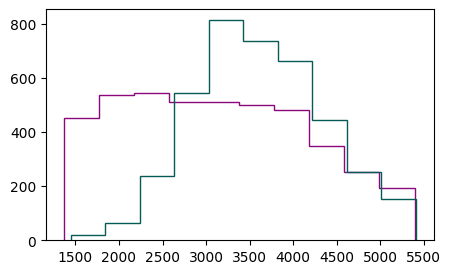

In [6]:
T_eff_posterior_1 = np.load('./retrieval_outputs/DENIS_J0255_nominal_5/test_data/T_eff_posterior.npy')
T_eff_posterior_2 = np.load('./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/T_eff_posterior.npy')

fig, ax = plt.subplots(figsize=(5,3))
ax.hist(T_eff_posterior_1, ec=posterior_color_1, fc='none', histtype='step')
ax.hist(T_eff_posterior_2, ec=posterior_color_2, fc='none', histtype='step')
plt.show()

In [10]:
4*np.pi*(4.8679*3.086e18)**2 * (np.median(T_eff_posterior_1)**4 * (5.67051e-8))

1.4119295968124635e+46

In [ ]:
print(np.quantile(T_eff_posterior_1, q=q)[2:5])
print(np.quantile(T_eff_posterior_2, q=q)[2:5])

In [ ]:

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_1, posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
#envelope_colors_1[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])
envelope_colors_1[:,-1] = np.array([0.1,0.3,0.5,0.7,0.9])

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])
#envelope_colors_2[:,-1] = np.array([0.1,0.3,0.5,0.7,0.9])


fig, ax = plt.subplots(
    figsize=(5,3), 
    gridspec_kw={'left':0.16, 'right':0.97, 'top':0.96, 'bottom':0.16}
    )

ax.fill_between(
    wave_1, scaled_flux_conf_interval_1[1], scaled_flux_conf_interval_1[-2], 
    fc=envelope_colors_1[2], ec='none', zorder=1
    )
ax.plot(
    wave_1, scaled_flux_conf_interval_1[3], c=posterior_color_1, lw=1, zorder=1, 
    )
ax.fill_betweenx(
    [np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], 
    fc=envelope_colors_1[2], ec=posterior_color_1, lw=1, 
    label='Free-chemistry'
    )

ax.fill_between(
    wave_2, scaled_flux_conf_interval_2[1], scaled_flux_conf_interval_2[-2], 
    fc=envelope_colors_2[2], ec='none', zorder=2.
    )
ax.plot(
    wave_2, scaled_flux_conf_interval_2[3], c=posterior_color_2, ls='--', lw=1, zorder=2
    )
ax.fill_betweenx(
    [np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], 
    fc=envelope_colors_2[2], ec=posterior_color_2, ls='--', lw=1, 
    label='Quenched equilibrium\nchemistry'
    )

filters = {
    '2MASS/2MASS.J': (12285.64, 1624.32), 
    '2MASS/2MASS.H': (16385.40, 2509.40), 
    '2MASS/2MASS.Ks': (21521.61, 2618.87), 
    'WISE/WISE.W1': (33154.27, 6626.42), 
    'WISE/WISE.W2': (45644.77, 10422.66), 
    }
colors = ['k', 'k', 'k', 'r', 'r']
for i, (key, val) in enumerate(magnitudes.items()):
    
    label = None
    if i == 0:
        label = '2MASS photometry'
        
    filt = species.ReadFilter(key)
    synphot = species.SyntheticPhotometry(key)
    int_flux, error = synphot.magnitude_to_flux(val[0], error=val[1])

    xerr = filters[key][1]*1e-4/2
    a, _, _ = ax.errorbar(
        filters[key][0]*1e-4, int_flux, yerr=error, xerr=xerr, 
        color=colors[i], elinewidth=2, marker='s', 
        markersize=4, zorder=3, label=label
        )

    '''
    ax.errorbar(
        filters[key][0]*1e-4, synth_flux_conf_interval[key][3], xerr=xerr, 
        yerr=np.abs(synth_flux_conf_interval[key][[2,-3]][:,None] - synth_flux_conf_interval[key][3]),  
        color=posterior_color_1, elinewidth=1.5, marker='s', markersize=3, zorder=4
        )
    '''

ax_CRIRES = ax.twinx()
for i in range(d_spec_2.n_orders):
    ax_CRIRES.plot([d_spec_2.wave[i].min()*1e-3, d_spec_2.wave[i].max()*1e-3], np.ones(2)*0.35, c='k', lw=1)
ax_CRIRES.annotate(
    r'CRIRES$^+$ K2166', xy=((0.5*d_spec_2.wave.min()+0.5*d_spec_2.wave.max())*1e-3,0.36), 
    ha='center', va='bottom', color='k'
)
ax_CRIRES.set(ylim=(0,1), yticks=[])


#ax.legend(loc='upper right')
ax.legend(
    loc='upper right', bbox_to_anchor=(1,1),
    labelspacing=0.6, fontsize=9, handlelength=1.5, handleheight=1.0
    )

ax.set(
    yscale='log', #xscale='log', 
    xlim=(1.0,2.5), ylim=(0.2e-14,0.3e-11), 
    #xlim=(1.0,6), ylim=(0.2e-15,0.3e-11), 
    xlabel=r'Wavelength ($\mu$m)', 
    ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$', 
    )
plt.savefig('./plots/low_res_comparison.pdf')
#plt.show()
plt.close()

## BT Settl T_eff test

In [ ]:
BT_SETTL_wave, BT_SETTL_flux = np.loadtxt('./data/ssap.txt').T

BT_SETTL_wave *= 1e-4 # convert from [A] to [um]

BT_SETTL_flux /= 1e-4 # convert from [erg/s/cm2/A] to [erg/s/cm2/um]
BT_SETTL_flux /= (1e-2)**2 # convert from [erg/s/cm2/um] to [erg/s/m2/um]
BT_SETTL_flux *= 1e-7 # convert from [erg/s/m2/um] to [W/m2/um]

print(
    (np.trapz(BT_SETTL_flux, x=BT_SETTL_wave) / (5.67051e-8))**(1/4)
)
BT_SETTL_flux *= (bestfit_params_2['params']['R_p']*nc.r_jup_mean / (1e3/bestfit_params_2['params']['parallax']*nc.pc))**2

plt.figure(figsize=(15,5))
plt.plot(BT_SETTL_wave, BT_SETTL_flux)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3,15)
plt.ylim(1e-16,3e-11)
#plt.ylim(1e-1,1e7)
plt.show()